In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
# %matplotlib inline
%config Completer.use_jedi = False

In [2]:
from datasets import InsectImgDataset
from utils import *
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.utils import class_weight

setting = 'photobox'
if setting == 'photobox':
    ext = '.png'
elif setting == 'fuji':
    ext = '.jpg'

Available workers: 8


In [3]:
dfs = InsectImgDataset(ext=ext, setting=setting, directory=DATA_DIR)
dfs.extract_df_info()
df = dfs.df

Extracting info from filenames..: 100%|█████| 26938/26938 [00:03<00:00, 8575.47it/s]


# Creating train,val,test sets

In [4]:
test_plates = train_test_split(df.platename.unique(), random_state=42, test_size=0.22, shuffle=True)[1].tolist()
testseries = pd.Series(test_plates)
inds = testseries.apply(lambda x: x.split('_')[1] == 'wortel')
inds = testseries[inds].sample(10).index.values
wortel_plates = testseries[inds].tolist()
test_plates = testseries[testseries.apply(lambda x: x.split('_')[1] != 'wortel')].tolist() + wortel_plates

df_trainval = df[~df.platename.isin(test_plates)]
df_test = df[df.platename.isin(test_plates)]

topclasses = df['label'].value_counts().head(10).index.tolist()

df = df[df['label'].isin(topclasses)]
df_test = df_test[df_test['label'].isin(topclasses)]

class_weights = class_weight.compute_class_weight('balanced', 
                                                  classes=np.unique(df['label'].tolist()), 
                                                  y=df['label'].tolist())

class_weights = {np.unique(df['label'])[i]:class_weights[i] for i in range(len(class_weights))}
df['weights'] = df['label'].map(class_weights)

df_train, df_val = train_test_split(df, test_size=0.15, random_state=42, shuffle=True)

le = LabelEncoder()
le.fit(df_train.label)

/tmp/ipykernel_21064/81752191.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weights'] = df['label'].map(class_weights)


LabelEncoder()

# Creating Pytorch Datasets and Dataloaders

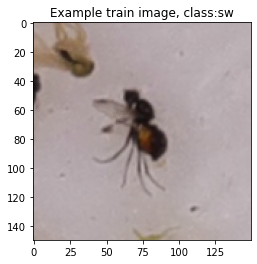

In [5]:
transforms_list_train = []
transforms_list_test = []

train_dataset = InsectImgDataset(df=df_train.reset_index(drop=True), transform=transforms.Compose(transforms_list_train))
valid_dataset = InsectImgDataset(df=df_val.reset_index(drop=True), transform=transforms.Compose(transforms_list_test))
test_dataset = InsectImgDataset(df=df_test.reset_index(drop=True), transform=transforms.Compose(transforms_list_test))

batch_size = 32
batch_size_val = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

plt.imshow(train_dataset[0][0].permute(1,2,0)); plt.title(f"Example train image, class:{train_dataset[0][1]}");

# Defining the model and training parameters

In [6]:
modelname = 'densenet121'
model = model_selector(modelname)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs,len(topclasses))

# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

num_epochs = 30

class_sample_count = np.unique(df_train.label, return_counts=True)[1]
weight = 1. / class_sample_count  
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(weight).cuda())

optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, cycle_momentum=False, mode="triangular2")

Train on gpu: True


# Training

In [7]:
results = {"loss":[], "val_loss":[], "train_accuracy":[], "valid_accuracy":[]}
best_valacc = 0
# Model training
for epoch in range(num_epochs):
    # Going through the training set
    correct_train = 0
    model.train()
    for x_batch,y_batch,imgname,platename,filename,plate_idx,location,date,year,xtra,width,height in tqdm(train_dataloader, desc='Training..\t'):        
        y_batch = torch.as_tensor(le.fit_transform(y_batch))#.type(torch.LongTensor)
        x_batch,y_batch = x_batch.float().cuda(), y_batch.cuda()
        for param in model.parameters():
            param.grad = None
        pred = model(x_batch)

        y_batch = y_batch.type(torch.LongTensor).cuda()
        correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
    train_accuracy = correct_train / len(train_dataset) * 100.
    
    # Going through the validation set
    correct_valid = 0
    model.eval()
    for x_batch,y_batch,imgname,platename,filename,plate_idx,location,date,year,xtra,width,height in tqdm(valid_dataloader, desc='Validating..\t'):
        y_batch = torch.as_tensor(le.fit_transform(y_batch))#.type(torch.LongTensor)
        x_batch,y_batch = x_batch.float().cuda(), y_batch.cuda()
        pred = model(x_batch)

        y_batch = y_batch.type(torch.LongTensor).cuda()
        correct_valid += (pred.argmax(axis=1) == y_batch).float().sum().item()
        val_loss = criterion(pred, y_batch)
    valid_accuracy = correct_valid / len(valid_dataset) * 100.

    scheduler.step()
#     early_stopping(val_loss, model)
#     if early_stopping.early_stop:
#         print("Early stopping")
#         break

        # Printing results
    print(f"Epoch {epoch}: train_acc: {train_accuracy:.1f}% loss: {loss:.7f},  val_loss: {val_loss:.7f} val_acc: {valid_accuracy:.1f}%")
        
    is_best = valid_accuracy > best_valacc
    if is_best:
        print(f"Validation accuracy improved from {best_valacc:.2f} to {valid_accuracy:.2f}. Saving model..")
    best_valacc = max(valid_accuracy, best_valacc)
    save_checkpoint({
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'best_valacc': best_valacc,
        'loss': results['loss'].append(loss.detach().cpu()),
        'val_loss': results['val_loss'].append(val_loss.detach().cpu()),
        'train_accuracy': results['train_accuracy'].append(train_accuracy),
        'valid_accuracy': results['valid_accuracy'].append(valid_accuracy),
        'optimizer' : optimizer.state_dict(),
    }, is_best, f"{modelname}")


Validating..	: 100%|██████████████████████████████| 120/120 [00:42<00:00,  2.81it/s]


Epoch 0: train_acc: 28.2% loss: 1.5544858,  val_loss: 1.7777592 val_acc: 34.0%
Validation accuracy improved from 0.00 to 34.00. Saving model..


Validating..	: 100%|██████████████████████████████| 120/120 [00:07<00:00, 16.14it/s]


Epoch 1: train_acc: 37.3% loss: 1.9593235,  val_loss: 2.1291678 val_acc: 42.3%
Validation accuracy improved from 34.00 to 42.28. Saving model..


Validating..	: 100%|██████████████████████████████| 120/120 [00:07<00:00, 16.52it/s]


Epoch 2: train_acc: 40.6% loss: 1.6520765,  val_loss: 1.8677242 val_acc: 39.9%


Validating..	: 100%|██████████████████████████████| 120/120 [00:07<00:00, 16.56it/s]


Epoch 3: train_acc: 44.3% loss: 1.2939434,  val_loss: 2.4970207 val_acc: 43.0%
Validation accuracy improved from 42.28 to 43.04. Saving model..


Validating..	: 100%|██████████████████████████████| 120/120 [00:07<00:00, 16.56it/s]


Epoch 4: train_acc: 46.4% loss: 2.1838949,  val_loss: 3.4600894 val_acc: 45.6%
Validation accuracy improved from 43.04 to 45.65. Saving model..


Validating..	: 100%|██████████████████████████████| 120/120 [00:07<00:00, 16.89it/s]


Epoch 5: train_acc: 47.4% loss: 1.7249848,  val_loss: 1.3768765 val_acc: 39.0%


Validating..	: 100%|██████████████████████████████| 120/120 [00:07<00:00, 16.83it/s]


Epoch 6: train_acc: 48.7% loss: 1.7630312,  val_loss: 1.3928310 val_acc: 48.1%
Validation accuracy improved from 45.65 to 48.13. Saving model..


Validating..	: 100%|██████████████████████████████| 120/120 [00:07<00:00, 16.85it/s]


Epoch 7: train_acc: 49.0% loss: 1.9991711,  val_loss: 1.1202668 val_acc: 48.1%


Validating..	: 100%|██████████████████████████████| 120/120 [00:07<00:00, 16.53it/s]


Epoch 8: train_acc: 50.9% loss: 1.7802536,  val_loss: 2.4128113 val_acc: 45.5%


Validating..	: 100%|██████████████████████████████| 120/120 [00:07<00:00, 16.48it/s]


Epoch 9: train_acc: 51.8% loss: 1.5892372,  val_loss: 1.2426419 val_acc: 46.8%


Validating..	: 100%|██████████████████████████████| 120/120 [00:07<00:00, 16.55it/s]


Epoch 10: train_acc: 50.5% loss: 1.0248576,  val_loss: 1.8789382 val_acc: 40.8%


Validating..	: 100%|██████████████████████████████| 120/120 [00:07<00:00, 16.60it/s]


Epoch 11: train_acc: 53.2% loss: 2.9369421,  val_loss: 2.0151069 val_acc: 45.0%


Validating..	: 100%|██████████████████████████████| 120/120 [00:07<00:00, 16.56it/s]


Epoch 12: train_acc: 54.6% loss: 2.4798663,  val_loss: 2.1218174 val_acc: 44.8%


Validating..	: 100%|██████████████████████████████| 120/120 [00:07<00:00, 16.44it/s]


Epoch 13: train_acc: 53.8% loss: 2.5961075,  val_loss: 3.5775890 val_acc: 45.6%


Validating..	: 100%|██████████████████████████████| 120/120 [00:07<00:00, 16.47it/s]


Epoch 14: train_acc: 56.1% loss: 1.9963990,  val_loss: 1.0800338 val_acc: 51.1%
Validation accuracy improved from 48.13 to 51.06. Saving model..


Validating..	: 100%|██████████████████████████████| 120/120 [00:07<00:00, 16.23it/s]


Epoch 15: train_acc: 55.4% loss: 0.6900522,  val_loss: 1.1325397 val_acc: 48.1%


Validating..	: 100%|██████████████████████████████| 120/120 [00:07<00:00, 16.47it/s]


Epoch 16: train_acc: 57.1% loss: 1.0651636,  val_loss: 1.8855603 val_acc: 43.0%


Validating..	: 100%|██████████████████████████████| 120/120 [00:07<00:00, 16.56it/s]


Epoch 17: train_acc: 57.6% loss: 2.4718444,  val_loss: 1.3553883 val_acc: 48.6%


Validating..	: 100%|██████████████████████████████| 120/120 [00:07<00:00, 16.56it/s]


Epoch 18: train_acc: 57.1% loss: 0.7230800,  val_loss: 1.5386299 val_acc: 37.8%


Validating..	: 100%|██████████████████████████████| 120/120 [00:07<00:00, 16.50it/s]


Epoch 19: train_acc: 59.1% loss: 0.5880991,  val_loss: 1.5549355 val_acc: 44.1%


Validating..	: 100%|██████████████████████████████| 120/120 [00:07<00:00, 16.41it/s]


Epoch 20: train_acc: 58.8% loss: 0.8494488,  val_loss: 2.1532605 val_acc: 49.8%


Validating..	: 100%|██████████████████████████████| 120/120 [00:07<00:00, 16.35it/s]


Epoch 21: train_acc: 58.8% loss: 0.8772272,  val_loss: 1.7607186 val_acc: 46.6%


Validating..	: 100%|██████████████████████████████| 120/120 [00:07<00:00, 16.28it/s]


Epoch 22: train_acc: 59.8% loss: 1.4865338,  val_loss: 2.4470148 val_acc: 48.8%


Validating..	: 100%|██████████████████████████████| 120/120 [00:07<00:00, 16.44it/s]


Epoch 23: train_acc: 60.7% loss: 1.2713583,  val_loss: 1.1136445 val_acc: 49.9%


Validating..	: 100%|██████████████████████████████| 120/120 [00:07<00:00, 15.93it/s]


Epoch 24: train_acc: 59.9% loss: 1.0535644,  val_loss: 1.5156944 val_acc: 48.2%


Validating..	: 100%|██████████████████████████████| 120/120 [00:07<00:00, 16.46it/s]


Epoch 25: train_acc: 62.7% loss: 2.0618761,  val_loss: 1.7153007 val_acc: 50.2%


Validating..	: 100%|██████████████████████████████| 120/120 [00:07<00:00, 16.62it/s]


Epoch 26: train_acc: 63.0% loss: 2.7371469,  val_loss: 1.9612846 val_acc: 48.4%


Validating..	: 100%|██████████████████████████████| 120/120 [00:07<00:00, 16.70it/s]


Epoch 27: train_acc: 63.4% loss: 0.8474838,  val_loss: 0.8539225 val_acc: 49.5%


Validating..	: 100%|██████████████████████████████| 120/120 [00:07<00:00, 16.56it/s]


Epoch 28: train_acc: 62.5% loss: 1.4501078,  val_loss: 1.2131699 val_acc: 48.2%


Validating..	: 100%|██████████████████████████████| 120/120 [00:07<00:00, 16.28it/s]


Epoch 29: train_acc: 63.3% loss: 0.7081159,  val_loss: 1.6065414 val_acc: 49.7%


In [9]:
dfs.extract_df_info()

Extracting info from filenames..: 100%|█████| 26938/26938 [00:03<00:00, 8373.67it/s]
